## setting the whole shabang

In [ ]:
%pip install pyodbc python-dotenv pandas tiktoken matplotlib openai numpy plotly scipy scikit-learn

In [36]:
# import dependencies
import csv
from dotenv import load_dotenv
import numpy as np
import openai
from openai.embeddings_utils import distances_from_embeddings
import os
import pandas as pd
import pyodbc
import tiktoken

In [37]:
# loading env
load_dotenv()

openai.organization = "org-" + os.getenv("OPENAI_ORG_ID")
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.Model.list() # this should return a list of models if credentials are correct

<OpenAIObject list at 0x7f695dccacf0> JSON: {
  "object": "list",
  "data": [
    {
      "id": "davinci",
      "object": "model",
      "created": 1649359874,
      "owned_by": "openai",
      "permission": [
        {
          "id": "modelperm-uJaD4C9nXA6tPNoBII9hcYF4",
          "object": "model_permission",
          "created": 1692634268,
          "allow_create_engine": false,
          "allow_sampling": true,
          "allow_logprobs": true,
          "allow_search_indices": false,
          "allow_view": true,
          "allow_fine_tuning": false,
          "organization": "*",
          "group": null,
          "is_blocking": false
        }
      ],
      "root": "davinci",
      "parent": null
    },
    {
      "id": "text-davinci-001",
      "object": "model",
      "created": 1649364042,
      "owned_by": "openai",
      "permission": [
        {
          "id": "modelperm-CDlahk1RbkghXDjtxqzXoPNo",
          "object": "model_permission",
          "created": 169091386

## creating a data frame from the database

In [38]:
# get the list of all Gandalf posts from the MSSQL db
user = os.environ["DB_USER"]
password = os.getenv("DB_PASSWORD")
server = os.getenv("DB_SERVER")
database = os.getenv("DB_NAME")

# ! you may need to change that if you're not using the ODBC Driver 17 for SQL Server
conn = pyodbc.connect(f"Driver={{ODBC Driver 17 for SQL Server}};Server={server};Database={database};UID={user};PWD={password}")
cursor = conn.cursor()
cursor.execute("SELECT name, url, description FROM posts")
rows = cursor.fetchall()

posts = []

for row in rows:
    posts.append({
        "name": row[0],
        "url": row[1],
        "description": row[2]
    })

# Create a dataframe from the rows
df = pd.DataFrame(posts, columns=["name", "url", "description"])

conn.close()

# export the dataframe to a csv file
df.to_csv('gandalf_posts.csv')
# df.head()

## counting DB tokens

<Axes: >

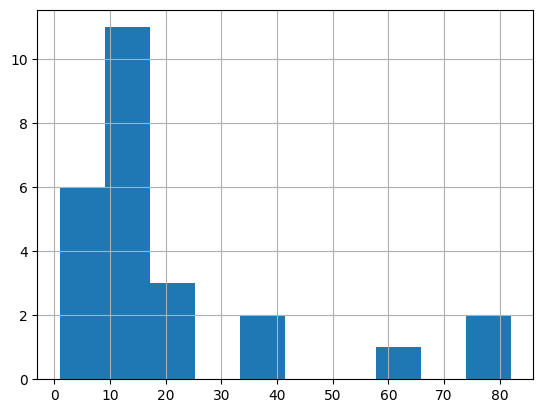

In [39]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

# TODO do the same thing with the tokens coming from the blog posts themselves
df = pd.read_csv('gandalf_posts.csv', index_col=0)
df.columns = ["name", "url", "description"]

# Tokenize the text and save the number of each description tokens to a new column
df['n_decription_tokens'] = df.description.apply(lambda x: len(tokenizer.encode(x)))
# Visualize the distribution of the number of tokens per row using a histogram
df.n_decription_tokens.hist()

## looping over descriptions to create embeddings

In [40]:
# creating the embeddings in the data frame
df["embeddings"] = df.description.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

# re rewriting the updated dataframe to a csv file
df.to_csv('gandalf_posts.csv')
df.head()

,name,url,description,n_decription_tokens,embeddings
0,Free for dev,https://gandalfrebootsorage.blob.core.windows....,Ressources gratuites pour les développeurs sur...,25,"[0.01791941188275814, -0.04225071519613266, 0...."
1,Ressources clouds gratuites,https://gandalfrebootsorage.blob.core.windows....,Ressources clouds,5,"[-0.00849062018096447, -0.02339393086731434, 0..."
2,Notre 1er Hackathon,https://gandalfrebootsorage.blob.core.windows....,"Ce qui est génial dans une jeune entreprise, c...",58,"[-0.008579655550420284, -0.03421454504132271, ..."
3,Gastronomie,https://gandalfrebootsorage.blob.core.windows....,Listes des bon restaurants aux alentours,9,"[0.007145988289266825, -0.00870937667787075, 0..."
4,Hackaton 2,https://gandalfrebootsorage.blob.core.windows....,description,1,"[-0.011262555606663227, -0.002783392323181033,..."


## flattening the embeddings into a 1-D NumPy array

In [41]:
df=pd.read_csv('gandalf_posts.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,name,url,description,n_decription_tokens,embeddings
0,Free for dev,https://gandalfrebootsorage.blob.core.windows....,Ressources gratuites pour les développeurs sur...,25,"[0.01791941188275814, -0.04225071519613266, 0...."
1,Ressources clouds gratuites,https://gandalfrebootsorage.blob.core.windows....,Ressources clouds,5,"[-0.00849062018096447, -0.02339393086731434, 0..."
2,Notre 1er Hackathon,https://gandalfrebootsorage.blob.core.windows....,"Ce qui est génial dans une jeune entreprise, c...",58,"[-0.008579655550420284, -0.03421454504132271, ..."
3,Gastronomie,https://gandalfrebootsorage.blob.core.windows....,Listes des bon restaurants aux alentours,9,"[0.007145988289266825, -0.00870937667787075, 0..."
4,Hackaton 2,https://gandalfrebootsorage.blob.core.windows....,description,1,"[-0.011262555606663227, -0.002783392323181033,..."


## creating the question context

In [42]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the description to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the descripition to the current length
        cur_len += row['n_decription_tokens']

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["description"])

    # Return the context
    return "\n\n###\n\n".join(returns)

## creating the answer context

In [43]:
def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [44]:
answer_question(df, question="Qu'est-ce qui est génial ?")

"Ce qui est génial dans une jeune entreprise, c'est que chaque action que nous faisons est historique."